### Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Evaluation
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learning Model
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

plt.style.use('seaborn')

## 1. Read Data

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')

In [3]:
data.columns=data.columns.str.replace(' ','')

In [4]:
bins = [0, 1400, 10000, np.inf]
data['category'] = pd.cut(data['shares'], bins, 
                          labels = ['Unpopular','Popular','Extremly_popular'])

In [5]:
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,category
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,Unpopular
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,Unpopular
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,Popular
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,Unpopular
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,Unpopular


## 2. Modelling

<a href=#p1>2.1 Baseline</a>

<a href=#p2>2.2 Feature Selection</a>

<a href=#p3>2.3 Feature Selection + UnderSampling</a>

<a href=#p4>2.4 Feature Selection + OverSampling</a>

<a href=#p5>2.5 Feature Selection + Model Tuning</a>

#### Split train and test set

In [6]:
X = data.drop(['url','timedelta','category','shares'],axis=1)
y = data['category']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2021)

#### Scaling data

In [8]:
numerical_features = ['n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords','kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess','LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']

In [9]:
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train_norm[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_norm[numerical_features] = scaler.transform(X_test_norm[numerical_features])

<a name='p1' /></a>
## 2.1 Baseline

#### NB & XGBoost

In [18]:
def model_fit(X_train_df,y_train_df,X_test_df):
    models = {
    "GaussianNB": GaussianNB(),

    "XGBooostClassifier": XGBClassifier()
    }

    prediction = dict()
    score_map = {}
    f1_map = {}

    for model_name in models:
        model = models[model_name]
        model.fit(X_train_df, y_train_df)
        prediction[model_name] = model.predict(X_test_df)
        score = accuracy_score(y_test, prediction[model_name])
        f1 = f1_score(y_test, prediction[model_name], average='macro')
        score_map[model_name] = score
        f1_map[model_name] = f1
        print("{}{}{}".format(model_name, " accuracy: ", score))
        print("{}{}{}".format(model_name, " f1 score: ", f1))

In [19]:
model_fit(X_train_norm,y_train,X_test_norm)

GaussianNB accuracy: 0.4919914238869971
GaussianNB f1 score: 0.3125687280412231
XGBooostClassifier accuracy: 0.609030142514819
XGBooostClassifier f1 score: 0.4277242447948552


#### Logistic 

In [16]:
logistic = LogisticRegression(random_state=2021,class_weight='balanced',solver='liblinear')
logistic_result = logistic.fit(X_train_norm, y_train)
y_pred = logistic_result.predict(X_test_norm)

In [22]:
print(classification_report(y_test, y_pred))
print("accuracy:", logistic_result.score(X_test_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66      4017
           1       0.60      0.51      0.55      3475
           2       0.15      0.26      0.19       437

    accuracy                           0.58      7929
   macro avg       0.47      0.48      0.47      7929
weighted avg       0.60      0.58      0.59      7929

accuracy: 0.5821667297263211
F1-score: 0.4677707725104985


#### Random Forest

In [25]:
rf= RandomForestClassifier(random_state=0,class_weight='balanced')
rf_result = rf.fit(X_train_norm, y_train)
y_pred1 = rf_result.predict(X_test_norm)

print("accuracy:",rf_result.score(X_test_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred1, average='macro'))

accuracy: 0.6148316307226637
F1-score: 0.4212579027858798


#### AdaBoost

In [11]:
ada_model = AdaBoostClassifier(random_state=2021)
ada_result = ada_model.fit(X_train_norm, y_train)
y_pred = ada_result.predict(X_test_norm)

In [13]:
print("accuracy:", ada_result.score(X_test_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

accuracy: 0.6100390969857485
F1-score: 0.4231520237821125


<a name='p2' /></a>
## 2.2 Feature Selection

#### Use multiple models to select key features by importance

In [35]:
models = {
    "Logistic": LogisticRegression(solver='liblinear'),
    
    "RandomForestClassifier":RandomForestClassifier(),
    
    "SupportVectorClassifier":SVC(kernel='linear'),
    
    #"GaussianNB": GaussianNB(),

    "XGBooostClassifier": XGBClassifier(),
    
    "AdaBoostClassifier":AdaBoostClassifier(),
    
    "LightGBMClassifier": LGBMClassifier()

}


feature_selection = {}
feature_names = np.array(X_train_norm.columns)

for model_name in models:
    model = models[model_name]
    selector = SelectFromModel(estimator=model,threshold=-1, max_features=25).fit(X_train_norm, y_train)
    feature_selection[model_name] = feature_names[selector.get_support()]
    print("{}{}{}".format(model_name, ": ", 'done'))

Logistic: done
RandomForestClassifier: done
SupportVectorClassifier: done
XGBooostClassifier: done
AdaBoostClassifier: done
LightGBMClassifier: done


#### select features using model votes >=3

In [36]:
feature_count = dict(zip(feature_names,np.zeros(len(feature_names))))
for i in feature_names:
    for j in feature_selection:
        if i in feature_selection[j]:
            feature_count[i]+=1
feature_count = pd.Series(feature_count).sort_values(ascending=False)

# select by feature count
features_selected = feature_count[feature_count>=3].index.tolist()

features_selected

['LDA_00',
 'n_unique_tokens',
 'kw_avg_avg',
 'kw_max_avg',
 'n_non_stop_unique_tokens',
 'kw_avg_min',
 'self_reference_min_shares',
 'global_subjectivity',
 'data_channel_is_tech',
 'kw_avg_max',
 'kw_min_avg',
 'LDA_02',
 'data_channel_is_socmed',
 'average_token_length',
 'is_weekend',
 'kw_min_min',
 'LDA_01',
 'self_reference_avg_sharess',
 'LDA_03',
 'data_channel_is_entertainment',
 'n_non_stop_words',
 'kw_max_min',
 'num_imgs',
 'data_channel_is_lifestyle',
 'data_channel_is_world',
 'data_channel_is_bus',
 'num_hrefs',
 'weekday_is_saturday']

In [10]:
features_selected=['LDA_00',
 'n_unique_tokens',
 'kw_avg_avg',
 'kw_max_avg',
 'n_non_stop_unique_tokens',
 'kw_avg_min',
 'self_reference_min_shares',
 'global_subjectivity',
 'data_channel_is_tech',
 'kw_avg_max',
 'kw_min_avg',
 'LDA_02',
 'data_channel_is_socmed',
 'average_token_length',
 'is_weekend',
 'kw_min_min',
 'LDA_01',
 'self_reference_avg_sharess',
 'LDA_03',
 'data_channel_is_entertainment',
 'n_non_stop_words',
 'kw_max_min',
 'num_imgs',
 'data_channel_is_lifestyle',
 'data_channel_is_world',
 'data_channel_is_bus',
 'num_hrefs',
 'weekday_is_saturday']

#### Scaling data

In [11]:
numerical_features_selected = [i for i in numerical_features if i in features_selected]

In [12]:
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]

In [13]:
X_train_selected_norm = X_train_selected.copy()
X_test_selected_norm = X_test_selected.copy()

scaler = StandardScaler()
scaler.fit(X_train[numerical_features_selected])
X_train_selected_norm[numerical_features_selected] = scaler.transform(X_train_selected_norm[numerical_features_selected])
X_test_selected_norm[numerical_features_selected] = scaler.transform(X_test_selected_norm[numerical_features_selected])

#### NB & XGBoost

In [15]:
model_fit(X_train_selected_norm,y_train,X_test_selected_norm)

GaussianNB accuracy: 0.4931264976667928
GaussianNB f1 score: 0.29948926216968813
XGBooostClassifier accuracy: 0.6106696935300795
XGBooostClassifier f1 score: 0.42179618620152687


#### Logistic 

In [36]:
logistic = LogisticRegression(random_state=2021,class_weight='balanced',solver='liblinear')
logistic_result_new = logistic.fit(X_train_selected_norm, y_train)
y_pred = logistic_result_new.predict(X_test_selected_norm)
print("Accuracy:",logistic_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.5764913608273426
F1-score: 0.4603217589494595


#### Random Forest

In [37]:
rf= RandomForestClassifier(random_state=0,class_weight='balanced')
rf_result_new = rf.fit(X_train_selected_norm, y_train)
y_pred = rf_result_new.predict(X_test_selected_norm)
print("Accuracy:",rf_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.6123092445453399
F1-score: 0.4195456627711007


#### AdaBoost

In [71]:
ada_model = AdaBoostClassifier(random_state=2021)
ada_result = ada_model.fit(X_test_selected_norm, y_train)
y_pred = ada_result.predict(X_test_selected_norm)

In [73]:
print("accuracy:", ada_result.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

accuracy: 0.6092823811325514
F1-score: 0.4185208957376654


<a name='p3' /></a>
## 2.3 Feature Selection + UnderSampling

In [20]:
rus = RandomUnderSampler()
X_train_selected_norm_RUS, y_train_RUS = rus.fit_resample(X_train_selected_norm, y_train)

#### NB & XGBoost

In [29]:
model_fit(X_train_selected_norm_RUS,y_train_RUS,X_test_selected_norm)

GaussianNB accuracy: 0.52894438138479
GaussianNB f1 score: 0.3773038394351366
XGBooostClassifier accuracy: 0.4748391978811956
XGBooostClassifier f1 score: 0.4124929097600029


#### Logistic

In [56]:
logistic = LogisticRegression(random_state=2021,class_weight='balanced',solver='liblinear')
logistic_result_new = logistic.fit(X_train_selected_norm_RUS, y_train_RUS)
y_pred_new = logistic_result_new.predict(X_test_selected_norm)
print("Accuracy:",logistic_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred_new, average='macro'))

Accuracy: 0.5158279732627066
F1-score: 0.4364396900832059


#### Random Forest

In [57]:
rf= RandomForestClassifier(random_state=2021,class_weight='balanced')
rf_result_new = rf.fit(X_train_selected_norm_RUS, y_train_RUS)
y_pred_new = rf_result_new.predict(X_test_selected_norm)
print("Accuracy:",rf_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred_new, average='macro'))

Accuracy: 0.6225249085635011
F1-score: 0.42662559551382523


#### AdaBoost

In [81]:
ada_model = AdaBoostClassifier(random_state=2021)
ada_result = ada_model.fit(X_train_selected_norm_RUS, y_train_RUS)
y_pred = ada_result.predict(X_test_selected_norm)

In [83]:
print("accuracy:", ada_result.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

accuracy: 0.47773994198511793
F1-score: 0.41521684203584686


<a name='p4' /></a>
## 2.4 Feature Selection + OverSampling

In [33]:
smote = SMOTE()
X_train_selected_norm_smote, y_train_smote = rus.fit_resample(X_train_selected_norm, y_train)

#### NB & XGBoost

In [34]:
model_fit(X_train_selected_norm_smote,y_train_smote,X_test_selected_norm)

GaussianNB accuracy: 0.5540421238491613
GaussianNB f1 score: 0.43105658755708665
XGBooostClassifier accuracy: 0.485180981208223
XGBooostClassifier f1 score: 0.4219694972822232


#### Logistic

In [50]:
logistic = LogisticRegression(random_state=2021,class_weight='balanced',solver='liblinear')
logistic_result_new = logistic.fit(X_train_selected_norm_smote, y_train_smote)
y_pred_new = logistic_result_new.predict(X_test_selected_norm)
print("Accuracy:",logistic_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred_new, average='macro'))

Accuracy: 0.5236473704124102
F1-score: 0.4425407501889067


#### Random Forest

In [51]:
rf= RandomForestClassifier(random_state=2021,class_weight='balanced')
rf_result_new = rf.fit(X_train_selected_norm_smote, y_train_smote)
y_pred_new = rf_result_new.predict((X_test_selected_norm)
print("Accuracy:",rf_result_new.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.6042376087779039
F1-score: 0.4615303753358741


#### AdaBoost

In [76]:
ada_model = AdaBoostClassifier(random_state=2021)
ada_result = ada_model.fit(X_train_selected_norm_smote, y_train_smote)
y_pred = ada_result.predict(X_test_selected_norm)

In [78]:
print("accuracy:", ada_result.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

accuracy: 0.5568167486442175
F1-score: 0.4636960258446134


<a name='p5' /></a>
## 2.5 Feature Selection + Model Tuning

### Bayes Tuning

In [40]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,
                 n_jobs = -1, 
                 scoring='accuracy') 
gs_NB.fit(X_train_selected_norm, y_train)

gs_NB.best_params_

{'var_smoothing': 0.8111308307896871}

In [41]:
prediction = gs_NB.predict(X_test_selected_norm)
score = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='macro')
print("{}{}{}".format('nb_classifier', " accuracy: ", score))
print("{}{}{}".format('nb_classifier', " f1 score: ", f1))

nb_classifier accuracy: 0.500693656198764
nb_classifier f1 score: 0.25676742033508554


### XGBoost Tuning

In [22]:
xgb_classifier = XGBClassifier()
params_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [2,5,7],
    'n_estimators': [50, 100, 200]
    }

gs_xgb = GridSearchCV(estimator=xgb_classifier, 
                 param_grid=params_xgb, 
                 cv=5,
                 n_jobs = -1,
                 verbose = 1,
                 scoring='accuracy') 
gs_xgb.fit(X_train_selected_norm, y_train)

gs_xgb.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [23]:
prediction = gs_xgb.predict(X_test_selected_norm)
score = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='macro')
print("{}{}{}".format('xgb_classifier', " accuracy: ", score))
print("{}{}{}".format('xgb_classifier', " f1 score: ", f1))

xgb_classifier accuracy: 0.6165973010467902
xgb_classifier f1 score: 0.4196585787719768


### Logistic Tuning

In [60]:
def clf_grid_cv(clf, search_spaces):
    
    pipe = Pipeline([('scl', StandardScaler()),
                    ('clf', clf)])
    
    grid_cv = GridSearchCV(pipe,
                            search_spaces,
                            cv=3,
                            n_jobs = -1,
                            refit = True
                           )
    grid_cv.fit(X_train_selected_norm, y_train)
    print("val. score: %s" % grid_cv.best_score_)
    print("test score: %s" % grid_cv.score(X_test_selected_norm, y_test))
    print("best params: %s" % str(grid_cv.best_params_))    
    
    return grid_cv

In [59]:
search_spaces_logi = {
    'clf__penalty' : ['l1', 'l2'],
    'clf__C' :  [100, 10, 1.0, 0.1, 0.01]
    }

In [64]:
clf_result = clf_grid_cv(LogisticRegression(random_state=2021,solver='liblinear'),search_spaces_logi)

val. score: 0.6099322129295283
test score: 0.6129398410896708
best params: {'clf__C': 10, 'clf__penalty': 'l2'}


In [81]:
logistic = LogisticRegression(random_state=2021,solver='liblinear',penalty= 'l2',C=10)
logistic.fit(X_train_selected_norm, y_train)
y_pred_new = logistic.predict(X_test_selected_norm)
print("Accuracy",logistic.score(X_test_selected_norm, y_test))
print("F1-score:", f1_score(y_pred_new,y_test,average='macro'))

Accuracy 0.613065960398537
F1-score: 0.41578603167369516


### Random Forest Tuning

In [85]:
search_spaces_rf = {
    'clf__max_depth': [10,20,50,80,100],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__n_estimators': [100, 200, 300, 1000]
    }

In [86]:
rf_result = clf_grid_cv(RandomForestClassifier(random_state=2021),search_spaces_rf)

val. score: 0.6262023225972527
test score: 0.6258040105940219
best params: {'clf__max_depth': 50, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 1000}


In [87]:
rf = RandomForestClassifier(random_state=2021,max_depth= 50, min_samples_leaf= 5, n_estimators= 1000)
rf.fit(X_train_selected_norm, y_train)
y_pred_new = rf.predict(X_test_selected_norm)
print("accuracy",rf.score(X_test_selected_norm, y_test))
print("F1-score:", f1_score(y_pred_new,y_test,average='macro'))

accuracy 0.6258040105940219
F1-score: 0.42614397491568784


### AdaBoost Tuning

In [14]:
ada = AdaBoostClassifier(random_state=2021)
search_spaces_ada = {
'clf__n_estimators':[10,50,100,500,1000],
'clf__learning_rate':[0.01,0.1,1,10,100],
    }

clf = GridSearchCV(ada, search_spaces_ada,scoring = 'roc_auc',cv=3,
                    n_jobs = -1,refit = True)

In [33]:
clf_result = clf_grid_cv(AdaBoostClassifier(random_state=2021),search_spaces_ada)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55062264 0.56178445 0.5632034  0.59637383 0.61333751 0.5640547
 0.59697288 0.61317984 0.62326977 0.62320666 0.59728847 0.61800412
 0.62194543 0.62251297 0.62021111 0.20611224 0.5067003  0.20611224
 0.5067003  0.20611224        nan        nan        nan        nan
        nan]
  warnings.warn(


val. score: 0.6232697653122603
test score: 0.6123092445453399
best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 500}


In [34]:
clf_result.best_params_

{'clf__learning_rate': 0.1, 'clf__n_estimators': 500}

In [19]:
ada_model = AdaBoostClassifier(random_state=2021, learning_rate=0.1, n_estimators=500)
ada_result = ada_model.fit(X_train_selected_norm, y_train)
y_pred = ada_result.predict(X_test_selected_norm)

In [21]:
print("accuracy:", ada_result.score(X_test_selected_norm,y_test))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

accuracy: 0.6123092445453399
F1-score: 0.41697418464834257


## Insights

In [14]:
rf = RandomForestClassifier(random_state=2021,max_depth= 50, min_samples_leaf= 5, n_estimators= 1000)
rf.fit(X_train_selected_norm, y_train)
y_pred_new = rf.predict(X_test_selected_norm)
print("accuracy",rf.score(X_test_selected_norm, y_test))
print("F1-score:", f1_score(y_pred_new,y_test,average='macro'))

accuracy 0.6125614831630722
F1-score: 0.41690422053424636


### Permutation Importance

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf).fit(X_test_selected_norm, y_test)
eli5.show_weights(perm, feature_names = X_test_selected_norm.columns.tolist())

Weight,Feature
0.0109 ± 0.0026,is_weekend
0.0078 ± 0.0037,kw_avg_avg
0.0067 ± 0.0032,data_channel_is_entertainment
0.0052 ± 0.0021,self_reference_min_shares
0.0036 ± 0.0011,data_channel_is_socmed
0.0035 ± 0.0030,kw_max_avg
0.0032 ± 0.0046,LDA_02
0.0030 ± 0.0021,kw_min_avg
0.0028 ± 0.0015,average_token_length
0.0024 ± 0.0018,global_subjectivity


### Partial Dependence Plot

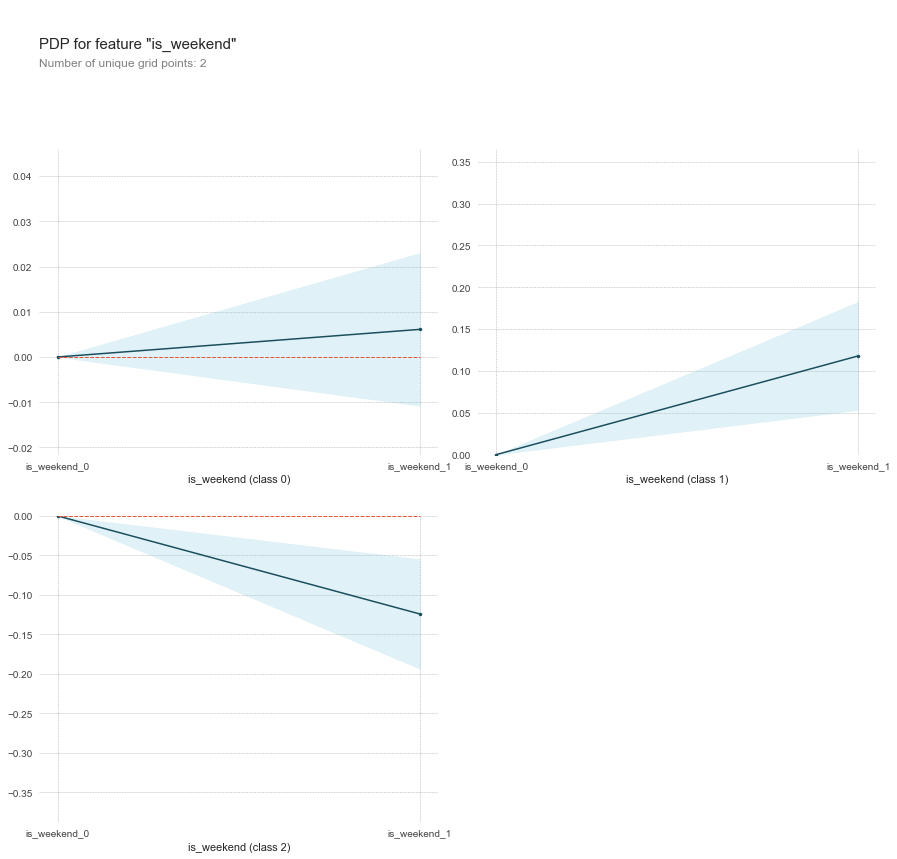

In [20]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test_selected_norm, model_features=X_test_selected_norm.columns.tolist(), feature='is_weekend')

# plot it
pdp.pdp_plot(pdp_goals, 'is_weekend')
plt.show()

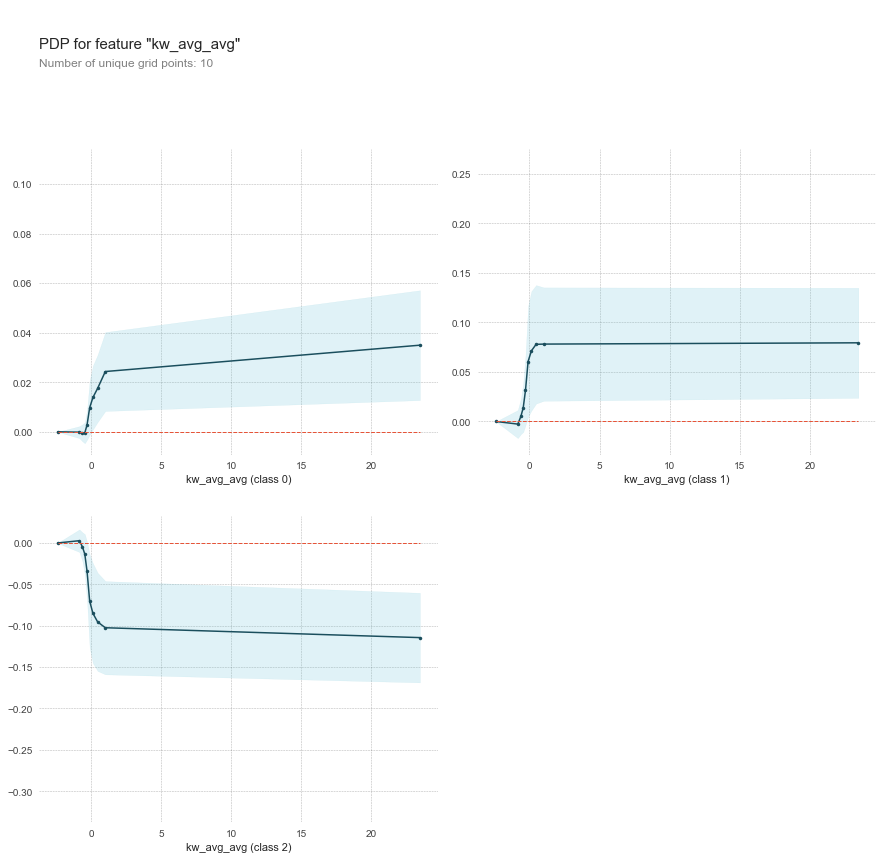

In [21]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test_selected_norm, model_features=X_test_selected_norm.columns.tolist(), feature='kw_avg_avg')

# plot it
pdp.pdp_plot(pdp_goals, 'kw_avg_avg')
plt.show()

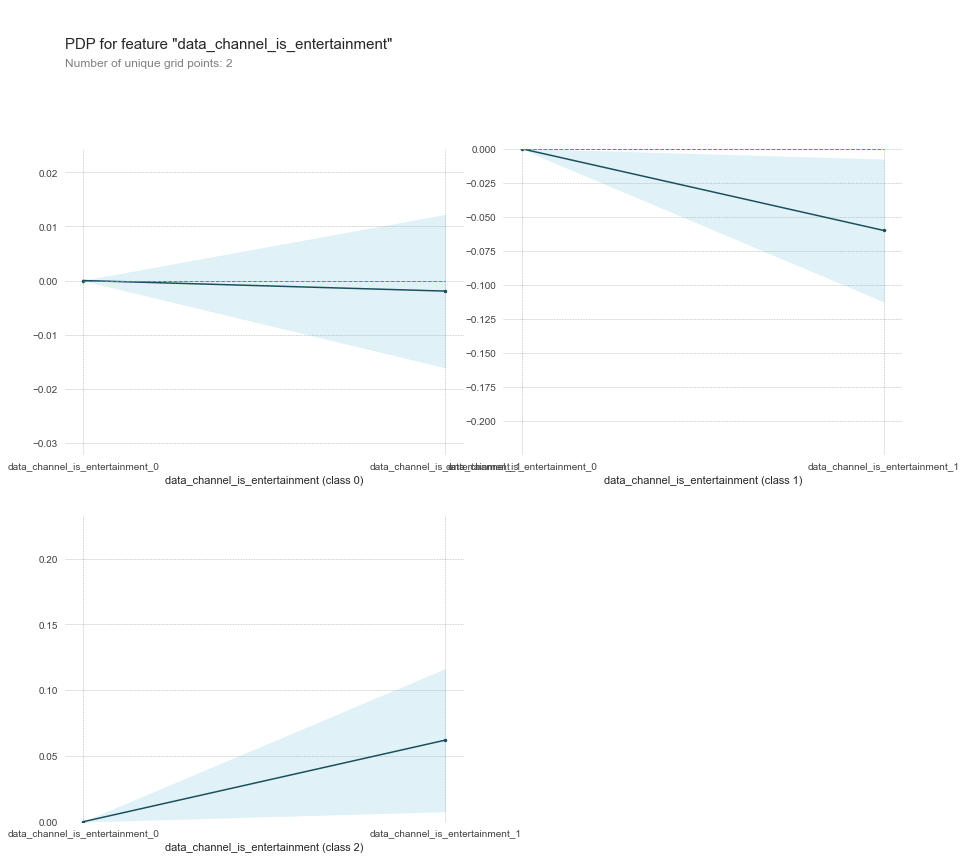

In [22]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test_selected_norm, model_features=X_test_selected_norm.columns.tolist(), feature='data_channel_is_entertainment')

# plot it
pdp.pdp_plot(pdp_goals, 'data_channel_is_entertainment')
plt.show()